In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
sys.path.append("../../")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ValueError: `dataset` input should have multiple elements.

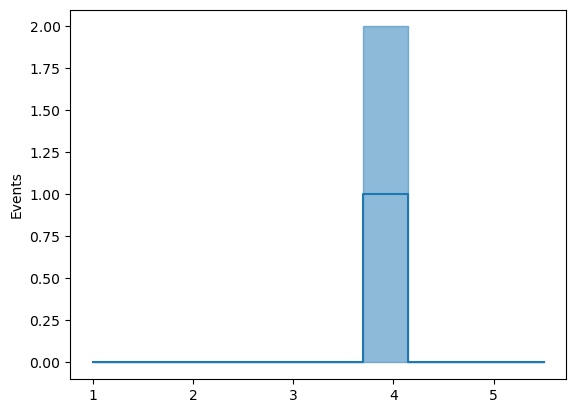

In [48]:
from microfit.histogram import Histogram, Binning
from microfit.statistics import fronebius_nearest_psd, covariance

from scipy.stats import gaussian_kde
from scipy.stats import norm
import random

def get_bootstrap_sample(data, weights, n_samples, rng=None):
    # Initialize a new random number generator
    if rng is None:
        rng = random.Random()
    # Randomly sample the data with replacement
    bootstrap_indices = rng.choices(range(len(data)), k=n_samples)
    bootstrap_data = data[bootstrap_indices]
    bootstrap_weights = weights[bootstrap_indices]
    return bootstrap_data, bootstrap_weights

def get_smoothed_histogram(data, weights, bins=10, density=True, bw_method="silverman", return_kernel_width=False):
    hist, bin_edges = np.histogram(data, bins=bins, weights=weights, density=density)
    kde = gaussian_kde(data, bw_method=bw_method, weights=weights)
    # To get smoothed bin counts, we want to integrate the PDF between bin edges.
    # Fortunately, the KDE already comes with that functionality.
    smoothed_hist = np.zeros(len(hist))
    for i in range(len(hist)):
        smoothed_hist[i] = kde.integrate_box_1d(bin_edges[i], bin_edges[i+1])
    # Keeping the total normalization constant
    smoothed_hist *= np.sum(hist) / np.sum(smoothed_hist)
    if return_kernel_width:
        return smoothed_hist, bin_edges, kde.factor
    else:
        return smoothed_hist, bin_edges

def get_smoothed_histogram_bootstrap(data, weights, bins=10, density=True, n_samples=100, seed=0):
    central_value, bin_edges, kde_factor = get_smoothed_histogram(data, weights, bins=bins, density=density, return_kernel_width=True)
    bootstrap_samples = []
    # We set the seed once so that the bootstrap samples are reproducible,
    # and reuse the same rng object to ensure that there is no collision between
    # the bootstrap samples and the random numbers used in the smoothing.
    rng = random.Random(seed)
    for i in range(n_samples):
        bootstrap_data, bootstrap_weights = get_bootstrap_sample(data, weights, len(data), rng=rng)
        # The KDE bandwidth is set to be equal to the one used to create the central value 
        # histogram. This ensures that the bootstrap samples are smoothed in the same way
        # and avoids pathological situations where, for instance, the bootstrap samples
        # are all using the same index and therefore the spread is zero.
        bootstrap_samples.append(
            get_smoothed_histogram(bootstrap_data, bootstrap_weights, bins=bin_edges, density=density, bw_method=kde_factor)[0]
        )
    bootstrap_samples = np.array(bootstrap_samples)
    
    covariance_matrix = covariance(bootstrap_samples, central_value, allow_approximation=True, tolerance=1e-10)
    return central_value, covariance_matrix

def repeat_last(inarr):
    return np.concatenate([inarr, inarr[-1:]])

fig, ax = plt.subplots()
# Plot the histogram without smoothing
bin_edges = np.linspace(1, 5.5, 11)
binning = Binning("energy", bin_edges)
unsmoothed_bin_counts = np.histogram(df['energy'], bins=bin_edges, weights=df["weights"])[0]
unsmoothed_uncertainties = np.sqrt(np.histogram(df['energy'], bins=bin_edges, weights=df["weights"]**2)[0])
unsmoothed_hist = Histogram(binning, unsmoothed_bin_counts, uncertainties=unsmoothed_uncertainties)
unsmoothed_hist.draw(ax, label='Unsmoothed')

# make a histogram with covariance matrix
smoothed_hist, cov = get_smoothed_histogram_bootstrap(df['energy'], df['weights'], bins=bin_edges, density=False)
hist_with_cov = Histogram(binning, smoothed_hist, covariance_matrix=cov)
hist_with_cov.draw(ax, label='Smoothed with covariance')

# Plot the KDE
kde = gaussian_kde(df['energy'])
x = np.linspace(bin_edges[0], bin_edges[-1], 100)
density_factor = sum(unsmoothed_bin_counts) * (bin_edges[1] - bin_edges[0])
ax.plot(x, kde(x) * density_factor, label='KDE', color="k")
ax.legend()
plt.show()

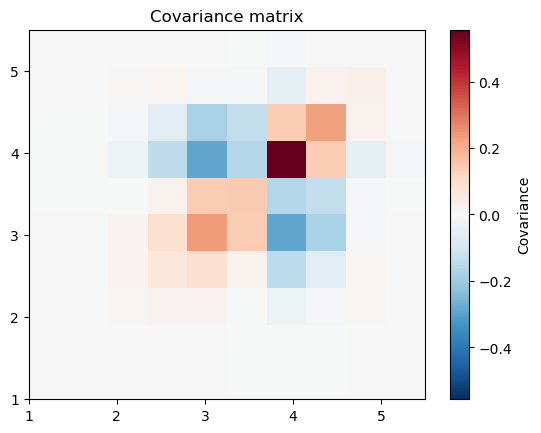

In [18]:
hist_with_cov.draw_covariance_matrix(as_fractional=False, as_correlation=False)

In [64]:
n_events = 100

np.random.seed(0)
df = pd.DataFrame()
df['energy'] = np.random.lognormal(1, 0.2, n_events)
df['angle'] = np.random.uniform(0, 3.14, n_events)
df['bdt'] = np.random.uniform(0, 1, n_events)
# df["weight"] = np.random.uniform(0, 1, n_events)
df["weights"] = 1

[0.24002839504399695]


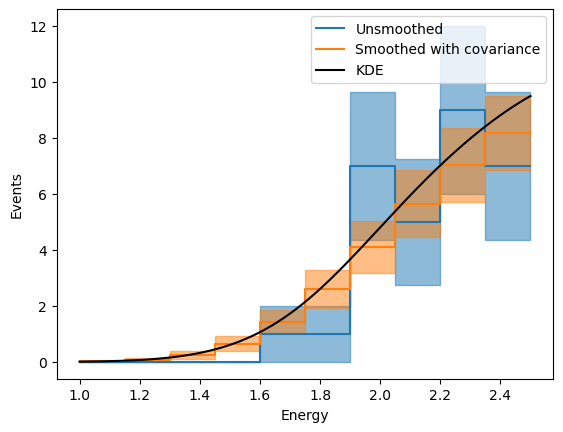

In [69]:
from microfit.histogram import Histogram, Binning, MultiChannelBinning, MultiChannelHistogram, HistogramGenerator
from microfit.statistics import fronebius_nearest_psd, covariance

from sklearn.neighbors import KernelDensity
from scipy import integrate
import random


def _get_query_mask(dataframe, query):
        """Get the boolean mask corresponding to the query."""
        if query is None:
            return np.ones(len(dataframe), dtype=bool)
        query_df = dataframe.query(query)
        query_indices = query_df.index
        mask = dataframe.index.isin(query_indices)
        return mask

def get_bootstrap_sample(data, weights, rng=None, method="poisson"):
    assert method in ["poisson", "choice"]
    # Initialize a new random number generator
    if rng is None:
        rng = random.Random()
    # Randomly sample the data with replacement
    if method == "choice":
        bootstrap_indices = rng.choices(range(len(data)), k=len(data))
        bootstrap_data = data[bootstrap_indices]
        bootstrap_weights = weights[bootstrap_indices]
    elif method == "poisson":
        bootstrap_weights = weights * np.random.poisson(1.0, size=len(weights))
        bootstrap_data = data
    return bootstrap_data, bootstrap_weights

def integrate_kde(kde: KernelDensity, bin_edges: np.ndarray, points_per_bin=100):
    # To get smoothed bin counts, we want to integrate the PDF between bin edges.
    # Fortunately, the KDE already comes with that functionality.
    smoothed_hist = np.zeros(len(bin_edges) - 1)
    for i in range(len(smoothed_hist)):
        lower, upper = bin_edges[i], bin_edges[i+1]
        def integrand(x):
            return np.exp(kde.score_samples(np.array(x).reshape(-1, 1)))
        x = np.linspace(lower, upper, points_per_bin)
        smoothed_hist[i] = integrate.trapz(integrand(x), x)
    return smoothed_hist

def get_smoothed_histogram(data, weights, bins=10, density=True, bw_method="silverman", return_kernel_width=False, kernel_width_floor=0.0, points_per_bin=100):
    hist, bin_edges = np.histogram(data, bins=bins, weights=weights, density=density)
    X = np.array(data).reshape(-1, 1)
    # Because we are using old scikit-learn, we have to apply scott and silverman
    # rules by hand
    data_std = np.std(data)
    # If we just have one sample, the std is zero and the KDE calculation would fail. 
    # To deal with this, we will assume that the data_std is never smaller than one
    # bin width.
    data_std = max(data_std, bin_width)
    if isinstance(bw_method, str):
        if bw_method == "scott":
            bw_method_ = X.shape[0] ** (-1 / (X.shape[1] + 4))
        elif bw_method == "silverman":
            bw_method_ = (X.shape[0] * (X.shape[1] + 2) / 4) ** (
                -1 / (X.shape[1] + 4)
            )
        bandwidth = max(bw_method_ * data_std, kernel_width_floor)
    else:
        bandwidth = bw_method
    kde = KernelDensity(bandwidth=bandwidth).fit(X, sample_weight=weights)
    # To get smoothed bin counts, we want to integrate the PDF between bin edges.
    smoothed_hist = integrate_kde(kde, bin_edges, points_per_bin=points_per_bin)
    if not density:
        smoothed_hist *= np.sum(hist) / np.sum(smoothed_hist)
    if return_kernel_width:
        return smoothed_hist, bin_edges, kde.bandwidth
    else:
        return smoothed_hist, bin_edges

def smooth_hist_multi_channel(data, weights, binning, selection_masks=None, **smooth_hist_kwargs):
    return_kernel_width = smooth_hist_kwargs.pop("return_kernel_width", False)
    bw_method = smooth_hist_kwargs.pop("bw_method", "silverman")
    if isinstance(bw_method, str):
        bw_method = [bw_method] * len(binning)
    elif isinstance(bw_method, float):
        bw_method = [bw_method] * len(binning)
    elif isinstance(bw_method, list):
        assert len(bw_method) == len(binning)
    if selection_masks is None:
        selection_masks = [np.ones(len(data), dtype=bool)] * len(binning)
    # To make a multi-channel histogram, we need to make a histogram for each channel
    # and then concatenate them together.
    central_value = []
    channel_bw = []
    for i, channel_binning in enumerate(binning):
        channel_cv, _, kde_factor = get_smoothed_histogram(
            data[:, i][selection_masks[i]],
            weights[selection_masks[i]],
            bins=channel_binning.bin_edges,
            return_kernel_width=True,
            bw_method=bw_method[i],
            **smooth_hist_kwargs
        )
        central_value.append(channel_cv)
        channel_bw.append(kde_factor)
    central_value = np.concatenate(central_value)
    if return_kernel_width:
        return central_value, channel_bw
    return central_value


def get_smoothed_histogram_bootstrap(dataframe, binning, n_samples=100, seed=0, method="poisson", return_bw=False, **smooth_hist_kwargs):
    return_kernel_width = smooth_hist_kwargs.pop("return_kernel_width", False)
    bw_method = smooth_hist_kwargs.pop("bw_method", "silverman")
    if not hasattr(binning, "variables"):
        binning = MultiChannelBinning([binning])
    selection_masks = []
    for i, query in enumerate(binning.selection_queries):
        selection_masks.append(_get_query_mask(dataframe, query))
    data = dataframe[binning.variables].values
    weights = dataframe["weights"].values
    central_value, channel_bw = smooth_hist_multi_channel(
        data, weights, binning, return_kernel_width=True, bw_method=bw_method, selection_masks=selection_masks, **smooth_hist_kwargs
    )
    bootstrap_samples = []
    # We set the seed once so that the bootstrap samples are reproducible,
    # and reuse the same rng object to ensure that there is no collision between
    # the bootstrap samples and the random numbers used in the smoothing.
    rng = random.Random(seed)
    for j in range(n_samples):
        bootstrap_data, bootstrap_weights = get_bootstrap_sample(data, weights, rng=rng, method=method)
        nonzero_mask = bootstrap_weights > 0
        if sum(nonzero_mask) == 0:
            bootstrap_samples.append(np.zeros_like(central_value))
            continue
        # The KDE bandwidth is set to be equal to the one used to create the central value 
        # histogram. This ensures that the bootstrap samples are smoothed in the same way
        # and avoids pathological situations where, for instance, the bootstrap samples
        # are all using the same index and therefore the spread is zero.
        sample_selection_masks = [selection_masks[i][nonzero_mask] for i in range(len(selection_masks))]
        bootstrap_samples.append(
            smooth_hist_multi_channel(
                bootstrap_data[nonzero_mask],
                bootstrap_weights[nonzero_mask],
                binning=binning,
                bw_method=channel_bw,
                selection_masks=sample_selection_masks,
                **smooth_hist_kwargs
            )
        )
    bootstrap_samples = np.array(bootstrap_samples)
    
    covariance_matrix = covariance(bootstrap_samples, central_value, allow_approximation=True, tolerance=1e-10)
    if return_kernel_width:
        return central_value, covariance_matrix, bootstrap_samples, channel_bw
    return central_value, covariance_matrix, bootstrap_samples

fig, ax = plt.subplots()
# Plot the histogram without smoothing
bin_edges = np.linspace(1, 2.5, 11)
binning = Binning("energy", bin_edges, label="Energy")
hist_generator = HistogramGenerator(df, binning)
unsmoothed_hist = hist_generator.generate()
unsmoothed_hist.draw(ax, label='Unsmoothed')

# make a histogram with covariance matrix
bin_width = bin_edges[1] - bin_edges[0]
smoothed_hist, cov, bootstrap_samples, channel_bw = get_smoothed_histogram_bootstrap(
    df, binning, density=False, return_kernel_width=True, bw_method="silverman", method="poisson"
)
print(channel_bw)
hist_with_cov = Histogram(binning, smoothed_hist, covariance_matrix=cov)
hist_with_cov.draw(ax, label='Smoothed with covariance')

# for bs_sample in bootstrap_samples:
#     hist = Histogram(binning, bs_sample, uncertainties=np.zeros_like(bs_sample))
#     hist.draw(ax, color="k", alpha=0.1, show_errors=False, lw=0.1)

# Plot the KDE
kde = KernelDensity(bandwidth=channel_bw[0]).fit(np.array(df['energy']).reshape(-1, 1))
x = np.linspace(bin_edges[0], bin_edges[-1], 1000)
density_factor = sum(df["weights"]) * (bin_edges[1] - bin_edges[0])
ax.plot(x,
        np.exp(kde.score_samples(np.array(x).reshape(-1, 1))) * density_factor,
        label='KDE', color="k")
        # Add vertical lines at the positions of the samples
# for i, sample in enumerate(df['energy']):
#     ax.axvline(x=sample, color='k', linestyle='--', label="samples" if i == 0 else None)

ax.legend()
# ax.set_ylim((0, 3))
plt.savefig("edge_binning.pdf")
plt.show()

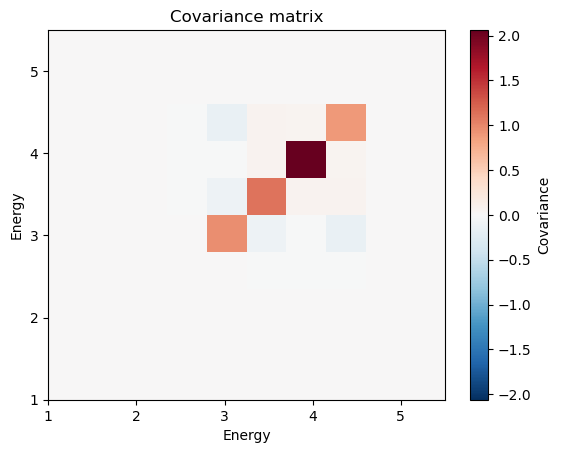

In [46]:
hist_with_cov.draw_covariance_matrix(as_fractional=False, as_correlation=False)
plt.savefig("five_events_covariance_very_small_bw.pdf")

In [10]:
import numpy as np
from microfit.histogram import Histogram, MultiChannelBinning, MultiChannelHistogram, Binning

def make_dataframe(self, n_samples=1000, data_like=False, with_multisim=False, weight_scale=1.0, seed=0):
    df = pd.DataFrame()
    np.random.seed(seed)
    # sampling energy from a slightly more realistic distribution
    df['energy'] = np.random.lognormal(0, 0.5, n_samples)
    df['angle'] = np.random.uniform(0, 3.14, n_samples)
    df['bdt'] = np.random.uniform(0, 1, n_samples)
    if data_like:
        df["weights"] = np.ones(n_samples)
        # data never contains multisim weights
        return df
    else:
        # make certain that weights are always positive and approximately 1
        df["weights"] = np.random.lognormal(0, 0.1, n_samples) * weight_scale
    if not with_multisim:
        return df
    # The 'weights_no_tune' column is used to calculate multisim uncertainties for GENIE
    # variables. For testing purposes, we just set it to the same as 'weights'.
    df["weights_no_tune"] = df["weights"]
    n_universes = 100
    for ms_column in ["weightsGenie", "weightsFlux", "weightsReint"]:
        df[ms_column] = [n_samples * np.random.normal(loc=1, size=n_universes, scale=0.1) for _ in range(len(df))]
    # Also add unisim "knob" weights
    knob_v = ["knobRPA", "knobCCMEC", "knobAxFFCCQE", "knobVecFFCCQE", "knobDecayAngMEC", "knobThetaDelta2Npi"]
    for knob in knob_v:
        df[f"{knob}up"] = 1.01
        df[f"{knob}dn"] = 0.99
    return df

rundata = {
    # Weight MC so that it corresponds to 100 samples
    "mc": make_dataframe(None, n_samples=1000, data_like=False, with_multisim=True, weight_scale=0.1),
    # The expectation is that data should match MC + EXT
    "data": make_dataframe(None, n_samples=110, data_like=True),
    "ext": make_dataframe(None, n_samples=10, data_like=True),
}

In [11]:
energy_binning = Binning("energy", np.linspace(0, 3, 10), "Energy")
energy_binning.selection_query = "angle > 1.5"
angle_binning = Binning("angle", np.linspace(0, 3, 10), "Angle")
angle_binning.selection_query = "energy > 1.5"
binning = MultiChannelBinning(
    binnings=[energy_binning, angle_binning],
)

In [12]:
binning.variables

['energy', 'angle']

In [13]:
binning["Energy"]

Binning(variable='energy', bin_edges=array([0.        , 0.33333333, 0.66666667, 1.        , 1.33333333,
       1.66666667, 2.        , 2.33333333, 2.66666667, 3.        ]), label='Energy', is_log=False, selection_query='angle > 1.5')

[0.179855607903906, 0.3346627386658133]


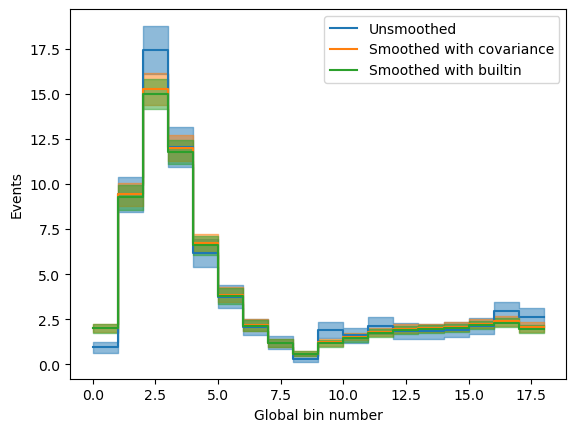

In [14]:
df = rundata["mc"]

fig, ax = plt.subplots()
hist_generator = HistogramGenerator(df, binning, enable_cache=False)
unsmoothed_hist = hist_generator.generate()
unsmoothed_hist.draw(ax, label='Unsmoothed')

# make a histogram with covariance matrix
bin_width = bin_edges[1] - bin_edges[0]
smoothed_hist, cov, channel_bw = get_smoothed_histogram_bootstrap(
    df, binning, density=False, return_kernel_width=True, bw_method="silverman", method="poisson"
)
print(channel_bw)
hist_with_cov = MultiChannelHistogram(binning, smoothed_hist, covariance_matrix=cov)
hist_with_cov.draw(ax, label='Smoothed with covariance')

# Use the builtin option in generate() to smooth the histogram
smoothed_hist = hist_generator.generate(use_kde_smoothing=True)
smoothed_hist.draw(ax, label="Smoothed with builtin")

ax.legend()
# ax.set_ylim((0, 5))
plt.show()

[0.179855607903906, 0.3346627386658133]


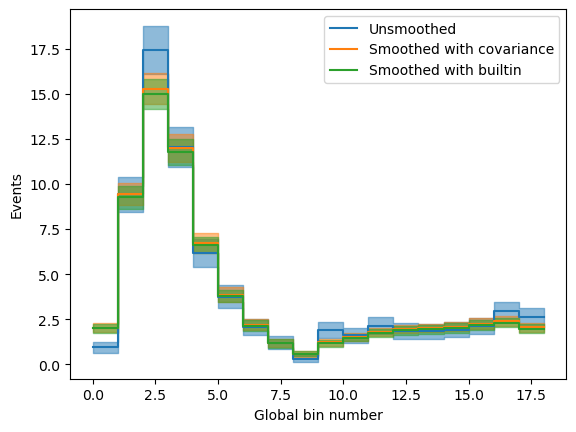

In [15]:
df = rundata["mc"]

fig, ax = plt.subplots()
hist_generator = HistogramGenerator(df, binning, enable_cache=False)
unsmoothed_hist = hist_generator.generate()
unsmoothed_hist.draw(ax, label='Unsmoothed')

# make a histogram with covariance matrix
bin_width = bin_edges[1] - bin_edges[0]
smoothed_hist, cov, channel_bw = get_smoothed_histogram_bootstrap(
    df, binning, density=False, return_kernel_width=True, bw_method="silverman", method="poisson"
)
print(channel_bw)
hist_with_cov = MultiChannelHistogram(binning, smoothed_hist, covariance_matrix=cov)
hist_with_cov.draw(ax, label='Smoothed with covariance')

# Use the builtin option in generate() to smooth the histogram
smoothed_hist = hist_generator.generate(use_kde_smoothing=True)
smoothed_hist.draw(ax, label="Smoothed with builtin")

ax.legend()
# ax.set_ylim((0, 5))
plt.show()

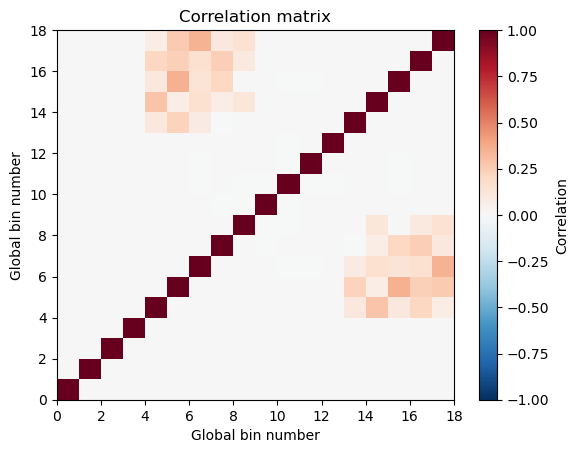

In [16]:
unsmoothed_hist.draw_covariance_matrix(as_fractional=False, as_correlation=True)

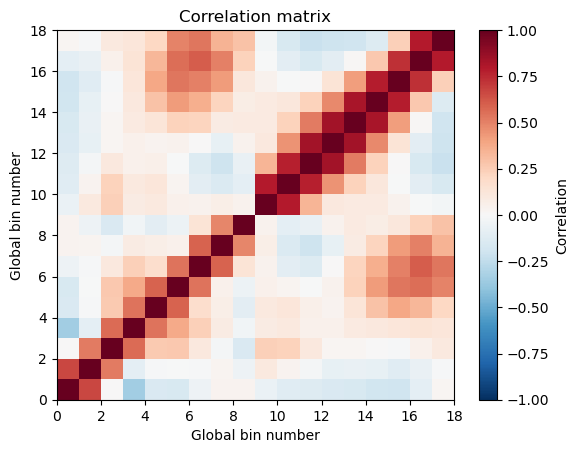

In [17]:
smoothed_hist.draw_covariance_matrix(as_fractional=False, as_correlation=True)

In [18]:
from microfit.histogram import RunHistGenerator
from microfit.run_plotter import RunHistPlotter

run_hist_generator = RunHistGenerator(rundata, binning["Energy"], enable_cache=False)

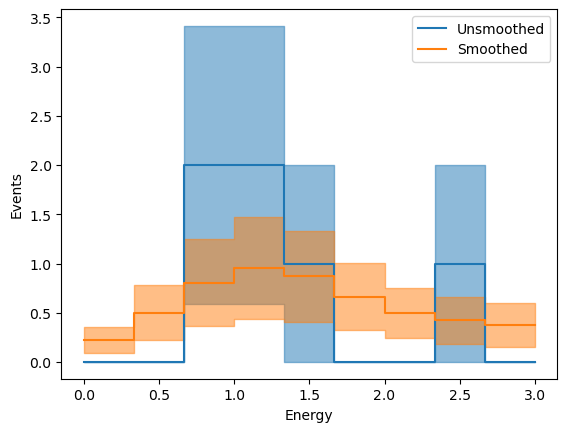

In [19]:
ext_hist = run_hist_generator.get_data_hist(type="ext", smooth_ext_histogram=False)
ext_hist_smooth = run_hist_generator.get_data_hist(type="ext", smooth_ext_histogram=True)

fig, ax = plt.subplots()
ext_hist.draw(ax, label="Unsmoothed", color="C0")
ext_hist_smooth.draw(ax, label="Smoothed", color="C1")
ax.legend()
plt.show()

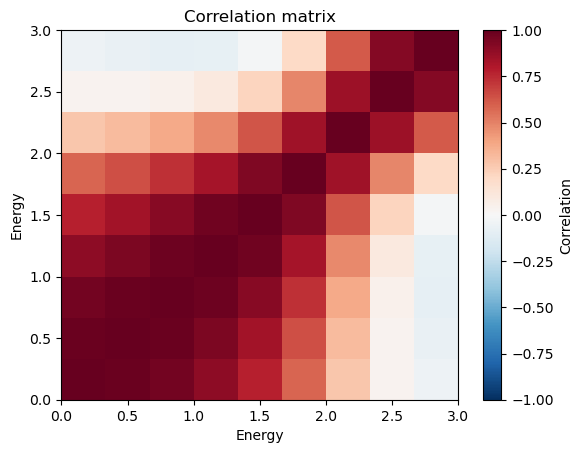

In [20]:
ext_hist_smooth.draw_covariance_matrix(as_fractional=False, as_correlation=True)


<AxesSubplot:title={'center':'No Presel. and No Sel.'}, xlabel='Energy', ylabel='Events'>

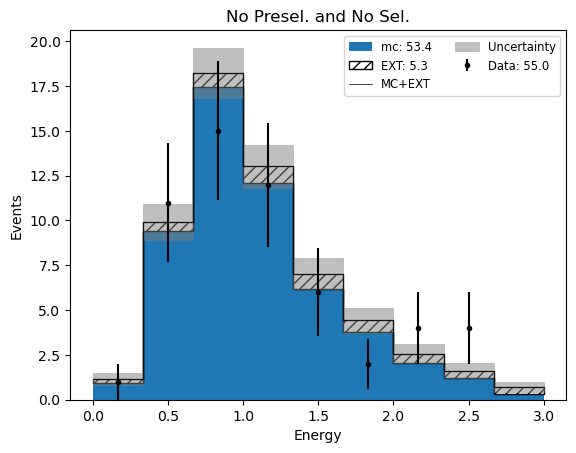

In [21]:
run_plotter = RunHistPlotter(run_hist_generator)
run_plotter.plot(add_ext_error_floor=False, smooth_ext_histogram=True)

In [22]:
n_nonzero = 2
np.random.seed(0)
nonzero_idx = np.random.choice(len(rundata["ext"]), n_nonzero, replace=False)
nonzero_mask = np.zeros(len(rundata["ext"]), dtype=bool)
nonzero_mask[nonzero_idx] = True
rundata["ext"]["weights"][nonzero_mask] = 1.0
rundata["ext"]["weights"][~nonzero_mask] = 0.0
# rundata["ext"]["weights"] = 1.0
rundata["ext"]

/Users/trettin/miniconda/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/trettin/miniconda/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,energy,angle,bdt,weights,dataset_name
0,2.415790,2.486017,0.978618,0.0,ext
1,1.221499,1.660730,0.799159,0.0,ext
2,1.631287,1.783660,0.461479,1.0,ext
3,3.066223,2.906373,0.780529,0.0,ext
4,2.544105,0.223053,0.118274,0.0,ext
5,0.613461,0.273586,0.639921,0.0,ext
6,1.608085,0.063486,0.143353,0.0,ext
7,0.927114,2.614426,0.944669,0.0,ext
8,0.949700,2.443412,0.521848,1.0,ext
9,1.227892,2.731838,0.414662,0.0,ext


<AxesSubplot:title={'center':'No Presel. and No Sel.'}, xlabel='Energy', ylabel='Events'>

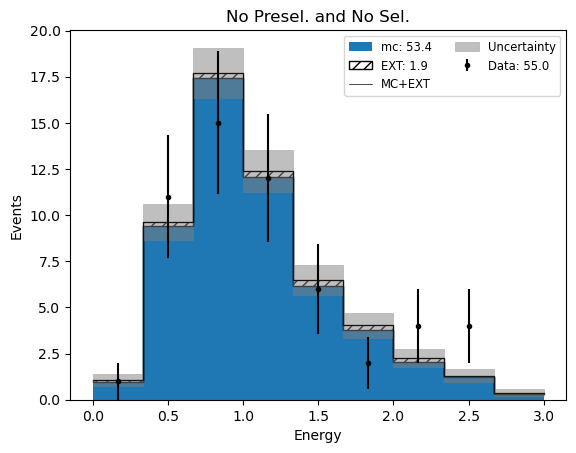

In [23]:
run_plotter = RunHistPlotter(run_hist_generator)
run_plotter.plot(add_ext_error_floor=False, smooth_ext_histogram=True)

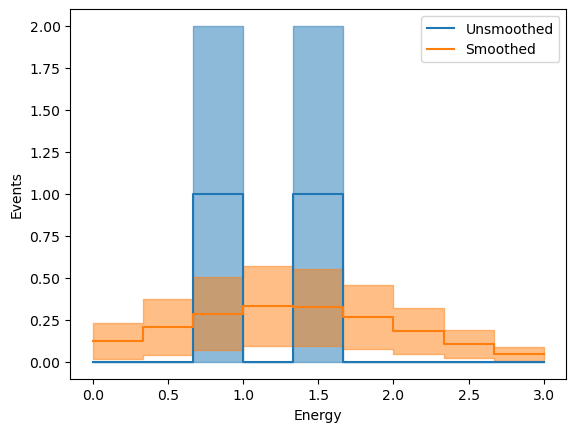

In [24]:
ext_hist = run_hist_generator.get_data_hist(type="ext", smooth_ext_histogram=False)
ext_hist_smooth = run_hist_generator.get_data_hist(type="ext", smooth_ext_histogram=True)

fig, ax = plt.subplots()
ext_hist.draw(ax, label="Unsmoothed", color="C0")
ext_hist_smooth.draw(ax, label="Smoothed", color="C1")
ax.legend()
plt.show()